# Sales Prediction Model

## A  regression model to predict future sales based on historical data. This helps in forecasting and planning for inventory,marketing, and budgeting.

## Importing libraries 

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')



## Loading the Dataset

In [2]:
# Load the dataset
data = pd.read_csv("Datasets\BigMart Sales Data.csv")

In [3]:
# Check the first few rows
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Exploring the data

In [4]:
# Check for missing values
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
# Check datatype
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Cleaning : Filling the missing values

In [6]:
# Fill missing values for Item_Weight with the median
data['Item_Weight'] = data['Item_Weight'].fillna(data['Item_Weight'].median())

# Fill missing values for Outlet_Size with the mode (most frequent value)
data['Outlet_Size'] = data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0])

# Verify if all missing values are handled
print("Missing values after filling:", data.isnull().sum())

Missing values after filling: Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


# Dealing the categorical variables in data

## Splitting the data and selecting only the low cardinality columns and numerical columns as features

In [7]:
# Separate target from predictors
y = data.Item_Outlet_Sales
X = data.drop(['Item_Outlet_Sales'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Categorical columns excluding item identifier
selected_object_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 20
                    and X_train_full[cname].dtype == "object"]

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
#low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
#                      X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = selected_object_cols + numerical_cols


# Making X_train and X_valid
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# for nominal encoding)
#X_train_ord_en = X_train_full[my_cols_ord_en].copy()
#X_valid_ord_en = X_valid_full[my_cols_ord_en].copy()

## Categorical variables selected as features

In [8]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)



Categorical variables:
['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


## A function to train the Linear Regression model and validate the predicted result with the mean squared error and R2 score

In [9]:
# Function for comparing different approaches
def ln_score_dataset(X_train, X_valid, y_train, y_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    R2_score = r2_score(y_valid, preds)
    mse = mean_squared_error(y_valid, preds)
    return [R2_score, mse, preds]

## A function to train the Random Forest Regressor model and validate the predicted result with the mean squared error and R2 score

In [10]:
# Function for comparing different approaches
def rf_score_dataset(X_train, X_valid, y_train, y_valid):
    
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    R2_score = r2_score(y_valid, preds)
    mse = mean_squared_error(y_valid, preds)
    return [R2_score, mse, preds]


### We use 2 approaches to encode the low cardinality categorical variables 1)Ordinal Encoder 2) One-hot encoding

## Using OrdinalEncoder

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])



result_rf_oe = rf_score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print("Random Forest MSE(Ordinal Encoding):", result_rf_oe[1]) 
print("Random Forest R2 Score(Ordinal Encoding):", result_rf_oe[0]) 
result_lr_oe = ln_score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print("Linear Regression MSE(Ordinal Encoding):", result_lr_oe[1]) 
print("Linear Regression R2 Score(Ordinal Encoding):", result_lr_oe[0]) 




Random Forest MSE(Ordinal Encoding): 1315355.453812562
Random Forest R2 Score(Ordinal Encoding): 0.5505915213883945
Linear Regression MSE(Ordinal Encoding): 1426176.8255454898
Linear Regression R2 Score(Ordinal Encoding): 0.5127279432021414


## Using OneHotEncoder

In [12]:

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# One-hot encode categorical variables in training and validation sets
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# Ensure the one-hot encoded columns retain the same index as the original data
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Assign appropriate column names to the one-hot encoded features
OH_cols_train.columns = OH_encoder.get_feature_names_out(object_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names_out(object_cols)

# Remove the original categorical columns and replace with one-hot encoded columns
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Concatenate the one-hot encoded columns with the numerical columns
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
 


# Evaluate the models
result_rf_oh = rf_score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)
print("Random Forest MSE (One-Hot Encoding):", result_rf_oh[1])
print("Random Forest R2 Score (One-Hot Encoding):", result_rf_oh[0])

result_lr_oh = ln_score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)
print("Linear Regression MSE (One-Hot Encoding):", result_lr_oh[1])
print("Linear Regression R2 Score (One-Hot Encoding):", result_lr_oh[0])



Random Forest MSE (One-Hot Encoding): 1296817.4316363668
Random Forest R2 Score (One-Hot Encoding): 0.5569252803115238
Linear Regression MSE (One-Hot Encoding): 1283097.671081355
Linear Regression R2 Score (One-Hot Encoding): 0.5616128168249976


### Both linear regression and random forest model improved with one-hot encoding.

# Visualizing the Results

### a)Linear Regression with one hot encoding

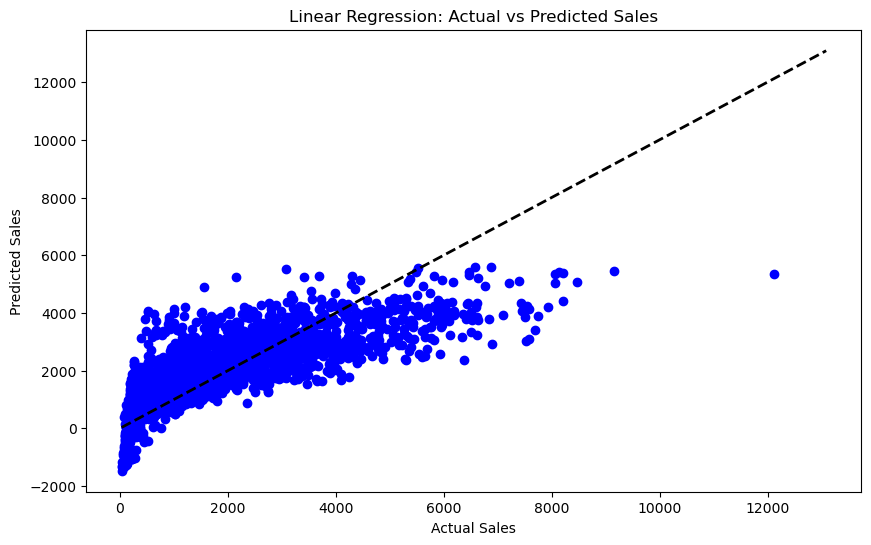

In [13]:
## Visualizing the Results(Linear regression model with One-Hot encoding)
# Plotting actual vs predicted values for Linear Regression model
plt.figure(figsize=(10,6))
plt.scatter(y_valid, result_lr_oh[2], color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted Sales')
plt.show()

## b) Random Forest model with One-Hot encoding

Text(0.5, 1.0, 'Random Forest: Actual vs Predicted Sales')

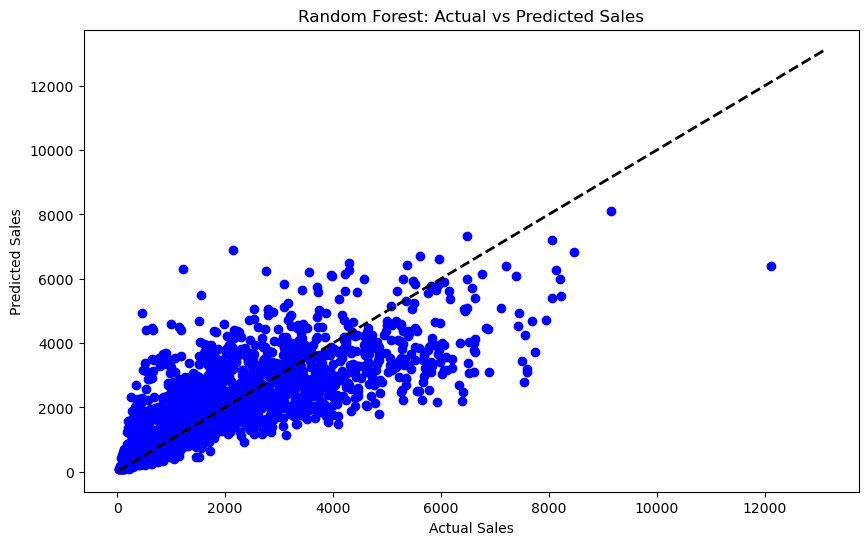

In [14]:
## Visualizing the Results(Random Forest model with One-Hot encoding)
# Plotting actual vs predicted values for Random Forest
plt.figure(figsize=(10,6))
plt.scatter(y_valid, result_rf_oh[2], color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Random Forest: Actual vs Predicted Sales')


## c)Random Forest with ordinal encoding

Text(0.5, 1.0, 'Random Forest: Actual vs Predicted Sales')

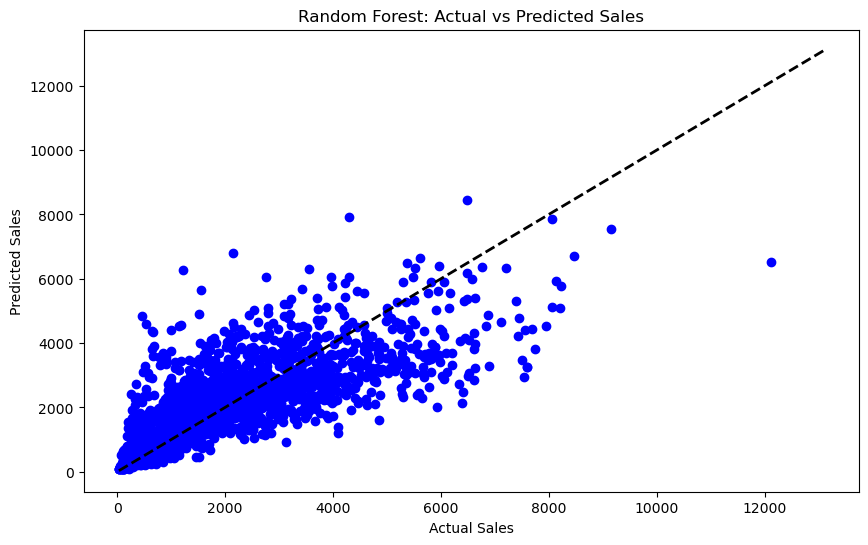

In [15]:
## Visualizing the Results(Random Forest model with ordinal encoding)
# Plotting actual vs predicted values for Random Forest
plt.figure(figsize=(10,6))
plt.scatter(y_valid, result_rf_oe[2], color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Random Forest: Actual vs Predicted Sales')

## d) Linear Regression model with ordinal encoding

Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted Sales')

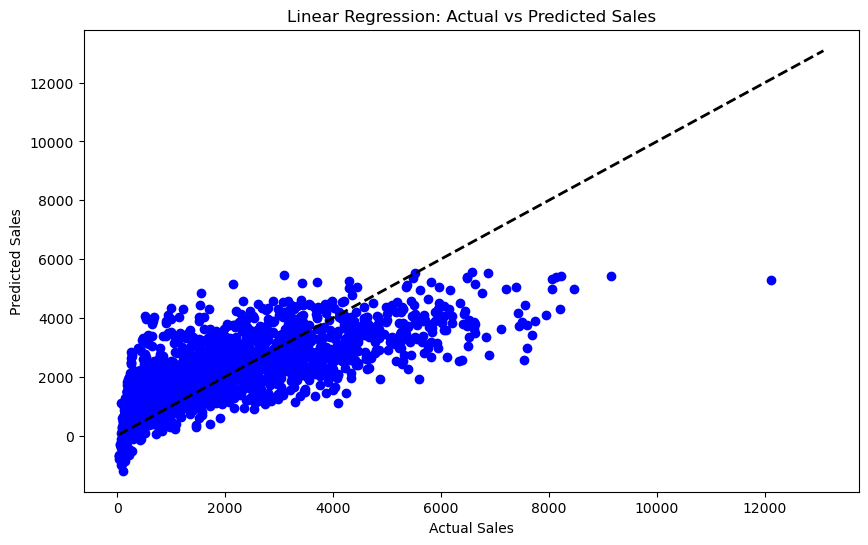

In [16]:
## Visualizing the Results(Linear Regression model with ordinal encoding)
# Plotting actual vs predicted values for Linear Regression model
plt.figure(figsize=(10,6))
plt.scatter(y_valid, result_lr_oe[2], color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted Sales')

### From the graphs it is obvious that the model performs well in lower sales, but in higher sales, it deviates from the actual value